#Instructions & Environment Set Up

Before running this code, please upload the GTSRB_255.zip file found [here](https://drive.google.com/file/d/19-ai19gwAv3tr5ohgRYMJWatotqKpwxU/view?usp=share_link). This takes several minutes. This notebook does require higher RAM to run, and premium GPU is helpful too. You can also opt to run the load the saved models and skip the training.

This notebook is built to run all the way through for all the models, but if running only one model, you only need to run the image size dataset appropriate for that model.
* 72x72: Vision Transformer
* 128x128: Haloi, Haloi Bayes
* 244x244: VGG16, ResNet50, Inception V3, MobileNet, Efficient Net

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Nov 30 16:36:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    42W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 18.2 MB/s 


In [ ]:
pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 33.1 MB/s 
     |████████████████████████████████| 1.6 MB 51.4 MB/s 


In [ ]:
# Upload to /content the file GTSRB_255.zip
!unzip /content/GTSRB_255.zip

Streaming output truncated to the last 5000 lines.
  inflating: GTSRB_255/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00042/00007_00015.jpg  
  inflating: GTSRB_255/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00042/00007_00029.jpg  
  inflating: GTSRB_255/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00042/00002_00026.jpg  
  inflating: GTSRB_255/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00042/00001_00006.jpg  
  inflating: GTSRB_255/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00042/00001_00012.jpg  
  inflating: GTSRB_255/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00042/00001_00013.jpg  
  inflating: GTSRB_255/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00042/00001_00007.jpg  
  inflating: GTSRB_255/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00042/00002_00027.jpg  
  inflating: GTSRB_255/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00042/00007_00028.jpg  
  inflating: GTSRB_255

# Data Processing

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
from time import time
import seaborn as sns
import time
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import tensorflow_probability as tfp
import tensorflow_addons as tfa
import keras_tuner as kt

from keras import utils
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model, Sequential, load_model
from keras.applications import MobileNetV2, EfficientNetB0
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.resnet import ResNet50, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
#file path if running in google colab
train_img_fp = '/content/GTSRB_255/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images'
test_img_fp = '/content/GTSRB_255/GTSRB_Final_Test_Images/GTSRB/Final_Test'
test_csv_fp = '/content/GTSRB_255/GTSRB_Final_Test_GT/GT-final_test.csv'
blurry_test_img_fp = '/content/GTSRB_255/GTSRB_Final_Test_Images_Blurry/GTSRB/Final_Test_Blurry'
blurry_test_csv_fp = '/content/GTSRB_255/GTSRB_Final_Test_GT_Blurry/GT-final_test_blurry.csv'

# #load models, google colab
# # model_VT_saved = '/content/GTSRB_255/models/model_VT.h5'
# model_EfficientNet_saved = '/content/GTSRB_255/models/model_EfficientNet.h5'
# model_MobileNet_saved = '/content/GTSRB_255/models/model_MobileNet.h5'
# ResNet50_saved = '/content/GTSRB_255/models/ResNet50.h5'
# VGG16_saved = '/content/GTSRB_255/models/VGG16.h5'
# # haloi_modified_saved = '/content/GTSRB_255/models/haloi_modified.h5

# #if reading/writing to google drive
# from google.colab import drive
# drive.mount('/content/drive')

##alternative file paths if running locally on machine
# train_img_fp = 'GTSRB_255/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images'
# test_img_fp = 'GTSRB_255/GTSRB_Final_Test_Images/GTSRB/Final_Test'
# test_csv_fp = 'GTSRB_255/GTSRB_Final_Test_GT/GT-final_test.csv'
# blurry_test_img_fp = 'GTSRB_255/GTSRB_Final_Test_Images_Blurry/GTSRB/Final_Test_Blurry'
# blurry_test_csv_fp = 'GTSRB_255/GTSRB_Final_Test_GT_Blurry/GT-final_test_blurry.csv'

# #load models, local
# # VT model and Haloi Bayes could not be saved, retrain to use
# model_EfficientNet_saved = 'GTSRB_255/models/model_EfficientNet.h5'
# model_MobileNet_saved = 'GTSRB_255/models/model_MobileNet.h5'
# ResNet50_saved = 'GTSRB_255/models/ResNet50.h5'
# VGG16_saved = 'GTSRB_255/models/VGG16.h5'
# haloi_modified_saved = 'GTSRB_255/models/haloi_modified.h5

In [ ]:
df = pd.read_csv(test_csv_fp,sep=';')
labels = list(df['ClassId'])

blurry_df = pd.read_csv(blurry_test_csv_fp,sep=',')
blurry_labels = list(blurry_df['ClassId'])

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
normalize_layer = layers.Rescaling(1/255.)

## Image Size 72

In [ ]:
#the follow cells of code load images datasets for training, validation, testing
#and blurry testing with different image sizes
dataset_train_72 = utils.image_dataset_from_directory(train_img_fp,
                                                   batch_size=20,
                                                   image_size=(72,72),
                                                   validation_split=0.2,
                                                   subset="training",
                                                   seed=1)
dataset_val_72 = utils.image_dataset_from_directory(train_img_fp,
                                                 batch_size=20,
                                                 image_size=(72,72),
                                                 validation_split=0.2,
                                                 subset="validation",
                                                 seed=1)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


In [ ]:
dataset_test_72 = utils.image_dataset_from_directory(test_img_fp,
                                                  labels=labels,
                                                  image_size=(72,72),
                                                  shuffle=False                                                  
                                                  )

Found 12630 files belonging to 1 classes.


In [ ]:
blurry_test_72 = utils.image_dataset_from_directory(blurry_test_img_fp,
                                                  labels=blurry_labels,
                                                  image_size=(72,72),
                                                  shuffle=False                                                  
                                                  )

Found 50 files belonging to 1 classes.


In [ ]:
#the image datasets are autotuned, then normalized
#this method is applied to all image size datasets
dataset_train_72 = dataset_train_72.cache().prefetch(buffer_size=AUTOTUNE)
dataset_val_72 = dataset_val_72.cache().prefetch(buffer_size=AUTOTUNE)
dataset_test_72 = dataset_test_72.cache().prefetch(buffer_size=AUTOTUNE)
blurry_test_72 = blurry_test_72.cache().prefetch(buffer_size=AUTOTUNE)

dataset_train_norm_72 = dataset_train_72.map(lambda x,y: (normalize_layer(x),y))
dataset_val_norm_72 = dataset_val_72.map(lambda x,y: (normalize_layer(x),y))
dataset_test_norm_72 = dataset_test_72.map(lambda x,y: (normalize_layer(x),y))
blurry_test_norm_72 = blurry_test_72.map(lambda x,y: (normalize_layer(x),y))

## Image Size 128

In [ ]:
dataset_train_128 = utils.image_dataset_from_directory(train_img_fp,
                                                   batch_size=20,
                                                   image_size=(128,128),
                                                   validation_split=0.2,
                                                   subset="training",
                                                   color_mode='grayscale',
                                                   seed=1)
dataset_val_128 = utils.image_dataset_from_directory(train_img_fp,
                                                 batch_size=20,
                                                 image_size=(128,128),
                                                 validation_split=0.2,
                                                 color_mode='grayscale',
                                                 subset="validation",
                                                 seed=1)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


In [ ]:
dataset_test_128 = utils.image_dataset_from_directory(test_img_fp,
                                                  labels=labels,
                                                  image_size=(128,128),
                                                  shuffle=False,
                                                  color_mode='grayscale'                                                  
                                                  )

Found 12630 files belonging to 1 classes.


In [ ]:
blurry_test_128 = utils.image_dataset_from_directory(blurry_test_img_fp,
                                                  labels=blurry_labels,
                                                  image_size=(128,128),
                                                  shuffle=False,
                                                  color_mode='grayscale'                                                  
                                                  )

Found 50 files belonging to 1 classes.


In [ ]:
dataset_train_128 = dataset_train_128.cache().prefetch(buffer_size=AUTOTUNE)
dataset_val_128 = dataset_val_128.cache().prefetch(buffer_size=AUTOTUNE)
dataset_test_128 = dataset_test_128.cache().prefetch(buffer_size=AUTOTUNE)
blurry_test_128 = blurry_test_128.cache().prefetch(buffer_size=AUTOTUNE)

dataset_train_norm_128 = dataset_train_128.map(lambda x,y: (normalize_layer(x),y))
dataset_val_norm_128 = dataset_val_128.map(lambda x,y: (normalize_layer(x),y))
dataset_test_norm_128 = dataset_test_128.map(lambda x,y: (normalize_layer(x),y))
blurry_test_norm_128 = blurry_test_128.map(lambda x,y: (normalize_layer(x),y))

## Image Size 224

In [ ]:
dataset_train_224 = utils.image_dataset_from_directory(train_img_fp,
                                                   batch_size=20,
                                                   image_size=(224,224),
                                                   validation_split=0.2,
                                                   subset="training",
                                                   seed=1)
dataset_val_224 = utils.image_dataset_from_directory(train_img_fp,
                                                 batch_size=20,
                                                 image_size=(224,224),
                                                 validation_split=0.2,
                                                 
                                                 subset="validation",
                                                 seed=1)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


In [ ]:
dataset_test_224 = utils.image_dataset_from_directory(test_img_fp,
                                                  labels=labels,
                                                  image_size=(224,224),
                                                  shuffle=False                                                  
                                                  )

Found 12630 files belonging to 1 classes.


In [ ]:
blurry_test_224 = utils.image_dataset_from_directory(blurry_test_img_fp,
                                                  labels=blurry_labels,
                                                  image_size=(224,224),
                                                  shuffle=False                                                  
                                                  )

Found 50 files belonging to 1 classes.


In [ ]:
dataset_train_224 = dataset_train_224.cache().prefetch(buffer_size=AUTOTUNE)
dataset_val_224 = dataset_val_224.cache().prefetch(buffer_size=AUTOTUNE)
dataset_test_224 = dataset_test_224.cache().prefetch(buffer_size=AUTOTUNE)
blurry_test_224 = blurry_test_224.cache().prefetch(buffer_size=AUTOTUNE)

dataset_train_norm_224 = dataset_train_224.map(lambda x,y: (normalize_layer(x),y))
dataset_val_norm_224 = dataset_val_224.map(lambda x,y: (normalize_layer(x),y))
dataset_test_norm_224 = dataset_test_224.map(lambda x,y: (normalize_layer(x),y))
blurry_test_norm_224 = blurry_test_224.map(lambda x,y: (normalize_layer(x),y))

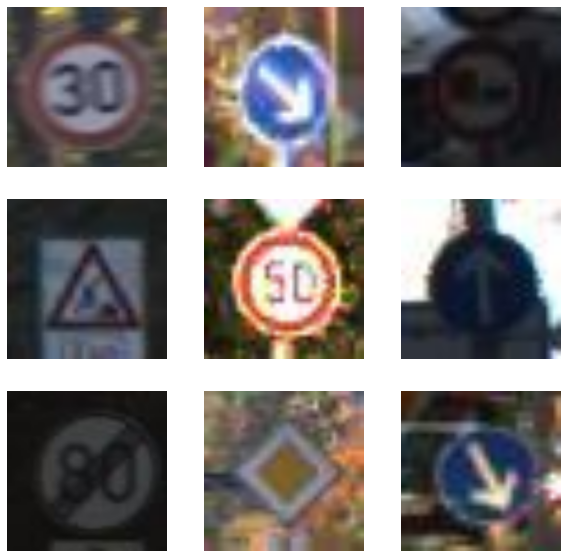

In [ ]:
# Diplay first nine images 
plt.figure(figsize=(10, 10))
for images, labels in dataset_train_224.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

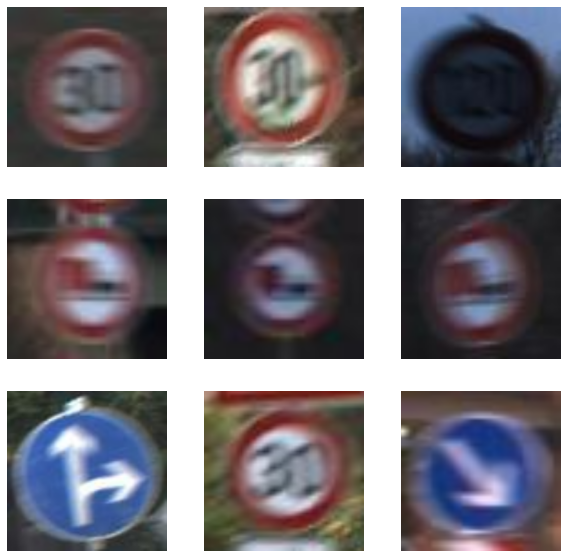

In [ ]:
# Diplay first nine blurry images 
plt.figure(figsize=(10, 10))
for images, labels in blurry_test_224.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

# Modify

In [ ]:
#variables are pulled out for easy modification
num_epochs = 20
num_trials = 10
tuner_epochs = 5
early_stop = [EarlyStopping(monitor='val_loss', patience=3)]

In [ ]:
#create dataframe for results without data
column_names = ["Model","Best Hyperparameters","Training Time", "Accuracy Score", "Top 5 Accuracy"]
results = pd.DataFrame([], columns=column_names)

# Build, Tune, Train Models

## Haloi

In [ ]:
class MyHyperModel(kt.HyperModel):
    '''create subclass of MyHyperModel class for tuning hyperparameters'''
    def build(self, hp):
      haloi_model = Sequential()

      # Conv, Max-pool (Haloi model layers 2,3)
      layer_1_input_shape = (128,128,1)

      haloi_model.add(layers.Conv2D(filters=64,
                                    kernel_size=(5,5),
                                    strides=(2,2),
                                    padding='same',
                                    kernel_initializer=keras.initializers.VarianceScaling(scale=2, distribution="truncated_normal"), 
                                    activation=layers.ReLU(),
                                    input_shape = layer_1_input_shape))
      haloi_model.add(layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same'))

      # Conv, Max-pool (Haloi model layers 5,6)
      haloi_model.add(layers.Conv2D(filters=192,
                                    kernel_size=(3,3),
                                    strides=(1,1),
                                    padding='same',
                                    activation=layers.ReLU()))
      haloi_model.add(layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same'))

      # mIncept_3a
      layer_8_input_shape = (16,16,192)

      mIncept_3a_inputs = keras.Input(shape=layer_8_input_shape)
      x1 = layers.Conv2D(filters=64,
                        kernel_size=(1,1),
                        strides=(1,1),
                        padding='same',
                        activation=layers.ReLU())(mIncept_3a_inputs)
      x2 = layers.Conv2D(filters=96,
                        kernel_size=(1,1),
                        strides=(1,1),
                        padding='same',
                        activation=layers.ReLU())(mIncept_3a_inputs)
      x2 = layers.Conv2D(filters=128,
                        kernel_size=(3,3),
                        strides=(1,1),
                        padding='same',
                        activation=layers.ReLU())(x2)
      x3 = layers.Conv2D(filters=16,
                        kernel_size=(1,1),
                        strides=(1,1),
                        padding='same',
                        activation=layers.ReLU())(mIncept_3a_inputs)
      x3 = layers.Conv2D(filters=32,
                        kernel_size=(5,5),
                        strides=(1,1),
                        padding='same',
                        activation=layers.ReLU())(x3)
      x4 = layers.Conv2D(filters=64,
                        kernel_size=(1,1),
                        strides=(1,1),
                        padding='same',
                        activation=layers.ReLU())(mIncept_3a_inputs)
      x4 = layers.Conv2D(filters=64,
                        kernel_size=(3,3),
                        strides=(1,1),
                        padding='same',
                        activation=layers.ReLU())(x4)
      x4 = layers.MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same')(x4)

      mIncept_3a_out = layers.Concatenate()([x1,x2,x3,x4])
      mIncept_3a = keras.Model(mIncept_3a_inputs,mIncept_3a_out, name='mIncept_3a')
      haloi_model.add(mIncept_3a)

      # mIncept_3b
      layer_10_input_shape = (16,16,288)

      mIncept_3b_inputs = keras.Input(shape=layer_10_input_shape)
      x1 = layers.Conv2D(filters=128,
                        kernel_size=(1,1),
                        strides=(1,1),
                        padding='same',
                        activation=layers.ReLU())(mIncept_3b_inputs)
      x2 = layers.Conv2D(filters=128,
                        kernel_size=(1,1),
                        strides=(1,1),
                        padding='same',
                        activation=layers.ReLU())(mIncept_3b_inputs)
      x2 = layers.Conv2D(filters=192,
                        kernel_size=(3,3),
                        strides=(1,1),
                        padding='same',
                        activation=layers.ReLU())(x2)
      x3 = layers.Conv2D(filters=32,
                        kernel_size=(1,1),
                        strides=(1,1),
                        padding='same',
                        activation=layers.ReLU())(mIncept_3b_inputs)
      x3 = layers.Conv2D(filters=96,
                        kernel_size=(5,5),
                        strides=(1,1),
                        padding='same',
                        activation=layers.ReLU())(x3)
      x4 = layers.Conv2D(filters=64,
                        kernel_size=(1,1),
                        strides=(1,1),
                        padding='same',
                        activation=layers.ReLU())(mIncept_3b_inputs)
      x4 = layers.Conv2D(filters=64,
                        kernel_size=(3,3),
                        strides=(1,1),
                        padding='same',
                        activation=layers.ReLU())(x4)
      x4 = layers.MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same')(x4)

      mIncept_3b_out = layers.Concatenate()([x1,x2,x3,x4])
      mIncept_3b = keras.Model(mIncept_3b_inputs,mIncept_3b_out, name='mIncept_3b')

      haloi_model.add(mIncept_3b)
      haloi_model.add(layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same'))

      # Avg-pool, dropout, linear, softmax (Haloi model layers 20,21,22,23)
      haloi_model.add(layers.Flatten()) #replaces haloi_model.add(layers.AveragePooling2D(pool_size=(8,8),strides=(1,1)))
      
      #hp options for drop out rate
      haloi_model.add(layers.Dropout(hp.Choice('dropout_rate', values=[.5, .6, .7, .8])))

      #hp options, added dense layer with hp neurons and hp activation function
      haloi_model.add(layers.Dense(units=hp.Int('hidden_layer', min_value=50, max_value=100, step=25),activation=hp.Choice('hidden_layer_activation', values=['relu', 'linear','sigmoid','leaky_relu'])))
      haloi_model.add(layers.Dense(43,activation='softmax'))
      haloi_model.summary()

      #model optimizer options
      hp_optimizer=hp.Choice('Optimizer', values=['Adam', 'SGD'])
      if hp_optimizer == 'Adam':
          optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3]))
      elif hp_optimizer == 'SGD':
          optimizer=keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3]),
          nesterov=True,
          momentum=hp.Choice('momentum', values=[.7, .8, .9]))

      haloi_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                          optimizer=optimizer, #hp option
                          metrics=[
                keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
            ])

      return haloi_model

In [ ]:
haloi_model = MyHyperModel()

tuner = kt.tuners.BayesianOptimization(
    haloi_model,
    seed=10,
    objective='val_loss',
    max_trials=num_trials,
    overwrite=True
    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 192)       110784    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 192)      0         
 2D)                                                             
                                                                 
 mIncept_3a (Functional)     (None, 16, 16, 288)       206800    
                                                                 
 mIncept_3b (Functional)     (None, 16, 16, 480)       4

In [ ]:
tuner.search(dataset_train_norm_128, epochs=tuner_epochs, batch_size=32, 
             validation_data=dataset_val_norm_128, callbacks=early_stop)

Trial 10 Complete [00h 02m 17s]
val_loss: 0.020588940009474754

Best val_loss So Far: 0.016430426388978958
Total elapsed time: 00h 23m 11s


In [ ]:
haloi_best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
#return list of best to worst hyperparams as objects, 0 index is the best
#object acts as a dict
print("Best Hyper-parameters")
haloi_best_hyperparameters.values #dict

Best Hyper-parameters


{'dropout_rate': 0.8,
 'hidden_layer': 50,
 'hidden_layer_activation': 'leaky_relu',
 'Optimizer': 'Adam',
 'learning_rate': 0.001,
 'momentum': 0.9}

In [ ]:
#build model with best hyperparameters
haloi_model=tuner.hypermodel.build(haloi_best_hyperparameters)

start_time = time()

#refit model with best hyperparameters
history=haloi_model.fit(dataset_train_norm_128, epochs=num_epochs, batch_size=32, 
                        validation_data=dataset_val_norm_128, callbacks=early_stop)

haloi_tt = round((time() - start_time) / 60, 2)
print('Haloi - Training Time: {} mins'.format(haloi_tt))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 64, 64, 64)        1664      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 192)       110784    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 192)      0         
 2D)                                                             
                                                                 
 mIncept_3a (Functional)     (None, 16, 16, 288)       206800    
                                                                 
 mIncept_3b (Functional)     (None, 16, 16, 480)      

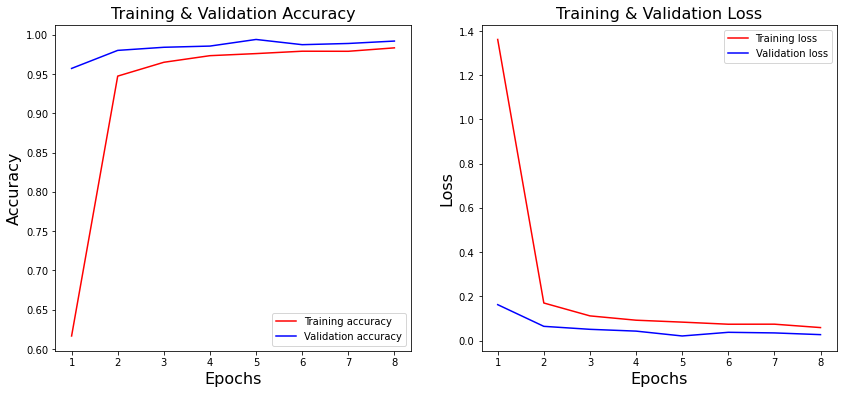

In [ ]:
#defines value to plot
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

#define x and y axis
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the model accuracy vs Epochs
ax[0].plot(epochs, accuracy, 'b', color='red', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()

# Plot the loss vs Epochs
ax[1].plot(epochs, loss_values, 'b', color='red', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

In [ ]:
loss, accuracy, top_5_accuracy = haloi_model.evaluate(dataset_test_norm_128)

395/395 [==============================] - 5s 6ms/step - loss: 0.1728 - accuracy: 0.9593 - top-5-accuracy: 0.9938


In [ ]:
blurry_loss, blurry_accuracy, blurry_top_5_accuracy = haloi_model.evaluate(blurry_test_norm_128)

2/2 [==============================] - 0s 77ms/step - loss: 0.0181 - accuracy: 1.0000 - top-5-accuracy: 1.0000


In [ ]:
#add metrics to results dataframe
new_row = ['Haloi', haloi_best_hyperparameters.values, haloi_tt, accuracy,top_5_accuracy]
results.loc[len(results)] = new_row

new_row = ['Haloi Blurry', None, None, blurry_accuracy, blurry_top_5_accuracy]
results.loc[len(results)] = new_row

results

,Model,Best Hyperparameters,Training Time,Accuracy Score,Top 5 Accuracy
0,Haloi,"{'dropout_rate': 0.8, 'hidden_layer': 100, 'hi...",1.95,0.959303,0.993824
1,Haloi Blurry,None,NaN,1.000000,1.000000


In [ ]:
haloi_model.save('haloi_modified.h5')

## Haloi Bayes

In [ ]:
class MyHyperModel(kt.HyperModel):
    '''create subclass of MyHyperModel class for tuning hyperparameters'''
    def build(self, hp):
      
      tfd = tfp.distributions

      # https://towardsdatascience.com/uncertainty-in-deep-learning-epistemic-uncertainty-and-bayes-by-backprop-e6353eeadebb
      def prior(kernel_size, bias_size=0, dtype=None):
        n = kernel_size + bias_size
        return tf.keras.Sequential([
            tfp.layers.VariableLayer(n, dtype=dtype),
            tfp.layers.DistributionLambda(lambda t: tfd.Independent(
                tfd.Normal(loc=t, scale=1),
                reinterpreted_batch_ndims=1)),
        ])
      def posterior(kernel_size, bias_size=0, dtype=None):
        n = kernel_size + bias_size
        c = np.log(np.expm1(1.))
        return tf.keras.Sequential([
            tfp.layers.VariableLayer(2 * n, dtype=dtype),
            tfp.layers.DistributionLambda(lambda t: tfd.Independent(
                tfd.Normal(loc=t[..., :n],
                          scale=1e-5 + .01 * tf.nn.softplus(c + t[..., n:])),
                reinterpreted_batch_ndims=1)),
        ])
      


      haloi_model = keras.Sequential()

      # Conv, Max-pool (Haloi model layers 2,3)
      layer_1_input_shape = (128,128,1)

      haloi_model.add(layers.Conv2D(filters=64,
                                    kernel_size=(5,5),
                                    strides=(2,2),
                                    padding='same',
                                    kernel_initializer=keras.initializers.VarianceScaling(scale=2, distribution="truncated_normal"), 
                                    activation=layers.ReLU(),
                                    input_shape = layer_1_input_shape))
      haloi_model.add(layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same'))

      # Conv, Max-pool (Haloi model layers 5,6)
      haloi_model.add(layers.Conv2D(filters=192,
                                    kernel_size=(3,3),
                                    strides=(1,1),
                                    padding='same',
                                    activation=layers.ReLU()))
      haloi_model.add(layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same'))

      # mIncept_3a

      layer_8_input_shape = (16,16,192)

      mIncept_3a_inputs = keras.Input(shape=layer_8_input_shape)
      x1 = layers.Conv2D(filters=64,
                        kernel_size=(1,1),
                        strides=(1,1),
                        padding='same',
                        activation=layers.ReLU())(mIncept_3a_inputs)
      x2 = layers.Conv2D(filters=96,
                        kernel_size=(1,1),
                        strides=(1,1),
                        padding='same',
                        activation=layers.ReLU())(mIncept_3a_inputs)
      x2 = layers.Conv2D(filters=128,
                        kernel_size=(3,3),
                        strides=(1,1),
                        padding='same',
                        activation=layers.ReLU())(x2)
      x3 = layers.Conv2D(filters=16,
                        kernel_size=(1,1),
                        strides=(1,1),
                        padding='same',
                        activation=layers.ReLU())(mIncept_3a_inputs)
      x3 = layers.Conv2D(filters=32,
                        kernel_size=(5,5),
                        strides=(1,1),
                        padding='same',
                        activation=layers.ReLU())(x3)
      x4 = layers.Conv2D(filters=64,
                        kernel_size=(1,1),
                        strides=(1,1),
                        padding='same',
                        activation=layers.ReLU())(mIncept_3a_inputs)
      x4 = layers.Conv2D(filters=64,
                        kernel_size=(3,3),
                        strides=(1,1),
                        padding='same',
                        activation=layers.ReLU())(x4)
      x4 = layers.MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same')(x4)

      mIncept_3a_out = layers.Concatenate()([x1,x2,x3,x4])
      mIncept_3a = keras.Model(mIncept_3a_inputs,mIncept_3a_out, name='mIncept_3a')
      #mIncept_3a.summary()
      haloi_model.add(mIncept_3a)

      # mIncept_3b

      layer_10_input_shape = (16,16,288)

      mIncept_3b_inputs = keras.Input(shape=layer_10_input_shape)
      x1 = layers.Conv2D(filters=128,
                        kernel_size=(1,1),
                        strides=(1,1),
                        padding='same',
                        activation=layers.ReLU())(mIncept_3b_inputs)
      x2 = layers.Conv2D(filters=128,
                        kernel_size=(1,1),
                        strides=(1,1),
                        padding='same',
                        activation=layers.ReLU())(mIncept_3b_inputs)
      x2 = layers.Conv2D(filters=192,
                        kernel_size=(3,3),
                        strides=(1,1),
                        padding='same',
                        activation=layers.ReLU())(x2)
      x3 = layers.Conv2D(filters=32,
                        kernel_size=(1,1),
                        strides=(1,1),
                        padding='same',
                        activation=layers.ReLU())(mIncept_3b_inputs)
      x3 = layers.Conv2D(filters=96,
                        kernel_size=(5,5),
                        strides=(1,1),
                        padding='same',
                        activation=layers.ReLU())(x3)
      x4 = layers.Conv2D(filters=64,
                        kernel_size=(1,1),
                        strides=(1,1),
                        padding='same',
                        activation=layers.ReLU())(mIncept_3b_inputs)
      x4 = layers.Conv2D(filters=64,
                        kernel_size=(3,3),
                        strides=(1,1),
                        padding='same',
                        activation=layers.ReLU())(x4)
      x4 = layers.MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same')(x4)

      mIncept_3b_out = layers.Concatenate()([x1,x2,x3,x4])
      mIncept_3b = keras.Model(mIncept_3b_inputs,mIncept_3b_out, name='mIncept_3b')
      #mIncept_3b.summary()
      haloi_model.add(mIncept_3b)

      haloi_model.add(layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same'))

      # Avg-pool, dropout, linear, softmax (Haloi model layers 20,21,22,23)

      haloi_model.add(layers.Flatten()) #replaces haloi_model.add(layers.AveragePooling2D(pool_size=(8,8),strides=(1,1)))
      #haloi_model.add(layers.Dropout(0.4))
      #haloi_model.add(layers.Dense(43,activation='linear'))
      haloi_model.add(tfp.layers.DenseVariational(43, make_prior_fn=prior, make_posterior_fn=posterior,activation='relu',kl_weight=1/10000000))
      haloi_model.add(layers.Dense(43, activation='softmax'))
      #haloi_model.add(layers.Softmax())

      haloi_model.summary()

      #model optimizer options
      hp_optimizer=hp.Choice('Optimizer', values=['Adam', 'SGD'])
      if hp_optimizer == 'Adam':
          optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3]))
      elif hp_optimizer == 'SGD':
          optimizer=keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3]),
          nesterov=True,
          momentum=hp.Choice('momentum', values=[.7, .8, .9]))

      haloi_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                          optimizer=optimizer, #hp option
                          metrics=[
                keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
            ])

      return haloi_model

In [ ]:
haloi_bayes_model = MyHyperModel()

tuner = kt.tuners.BayesianOptimization(
    haloi_bayes_model,
    seed=10,
    objective='val_loss',
    max_trials=num_trials,
    overwrite=True
    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 192)       110784    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 192)      0         
 2D)                                                             
                                                                 
 mIncept_3a (Functional)     (None, 16, 16, 288)       206800    
                                                                 
 mIncept_3b (Functional)     (None, 16, 16, 480)       4

In [ ]:
tuner.search(dataset_train_norm_128, epochs=tuner_epochs, batch_size=32, 
             validation_data=dataset_val_norm_128, callbacks=early_stop)

Trial 10 Complete [00h 01m 23s]
val_loss: 0.6100867390632629

Best val_loss So Far: 0.5675620436668396
Total elapsed time: 00h 13m 54s


In [ ]:
haloi_bayes_best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
#return list of best to worst hyperparams as objects, 0 index is the best
#object acts as a dict
print("Best Hyper-parameters")
haloi_bayes_best_hyperparameters.values #dict

Best Hyper-parameters


{'Optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0.7}

In [ ]:
#build model with best hyperparameters
haloi_bayes_model=tuner.hypermodel.build(haloi_bayes_best_hyperparameters)

start_time = time()

#refit model with best hyperparameters
history=haloi_bayes_model.fit(dataset_train_norm_128, epochs=num_epochs, batch_size=32, 
                        validation_data=dataset_val_norm_128, callbacks=early_stop)

haloi_bayes_tt = round((time() - start_time) / 60, 2)
print('Haloi - Training Time: {} mins'.format(haloi_bayes_tt))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 64, 64, 64)        1664      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 192)       110784    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 192)      0         
 2D)                                                             
                                                                 
 mIncept_3a (Functional)     (None, 16, 16, 288)       206800    
                                                                 
 mIncept_3b (Functional)     (None, 16, 16, 480)      

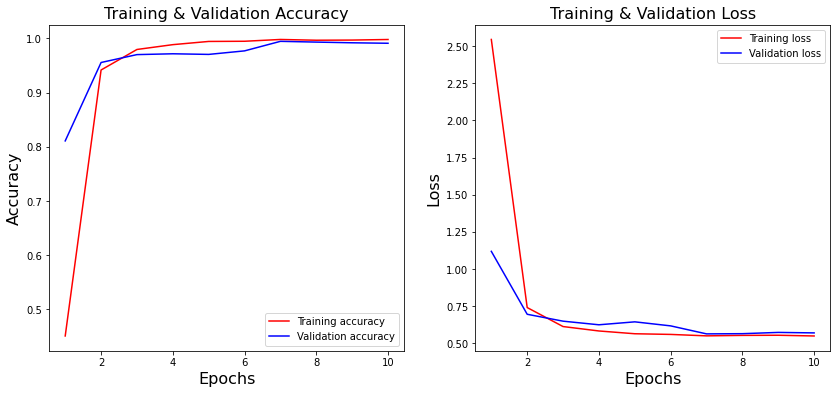

In [ ]:
#defines value to plot
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

#define x and y axis
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the model accuracy vs Epochs
ax[0].plot(epochs, accuracy, 'b', color='red', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()

# Plot the loss vs Epochs
ax[1].plot(epochs, loss_values, 'b', color='red', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

In [ ]:
loss, accuracy, top_5_accuracy = haloi_bayes_model.evaluate(dataset_test_norm_128)

395/395 [==============================] - 2s 5ms/step - loss: 0.8394 - accuracy: 0.9467 - top-5-accuracy: 0.9920


In [ ]:
blurry_loss, blurry_accuracy, blurry_top_5_accuracy = haloi_bayes_model.evaluate(blurry_test_norm_128)

2/2 [==============================] - 0s 6ms/step - loss: 0.6704 - accuracy: 0.9600 - top-5-accuracy: 1.0000


In [ ]:
#add metrics to results dataframe
new_row = ['Haloi Bayes', haloi_bayes_best_hyperparameters.values, haloi_bayes_tt, accuracy,top_5_accuracy]
results.loc[len(results)] = new_row

new_row = ['Haloi Bayes Blurry', None, None, blurry_accuracy, blurry_top_5_accuracy]
results.loc[len(results)] = new_row

results

,Model,Best Hyperparameters,Training Time,Accuracy Score,Top 5 Accuracy
0,Haloi,"{'dropout_rate': 0.8, 'hidden_layer': 100, 'hi...",1.95,0.959303,0.993824
1,Haloi Blurry,None,NaN,1.000000,1.000000
2,Haloi Bayes,"{'Optimizer': 'SGD', 'learning_rate': 0.01, 'm...",2.63,0.946714,0.992003
3,Haloi Bayes Blurry,None,NaN,0.960000,1.000000


In [ ]:
# #cannot save this model
# haloi_bayes_model.save('haloi_bayes_modified.h5')

## Vision transformer

In [ ]:
num_classes = 43
input_shape = (72, 72, 3)

In [ ]:
#set the hyperparameters
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
#Implement multilayer perceptron (MLP)
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
# Implement the patch encoding layer
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
# Implement patch creation as a layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


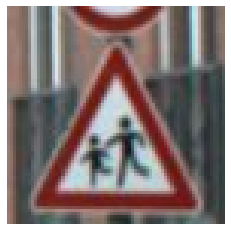

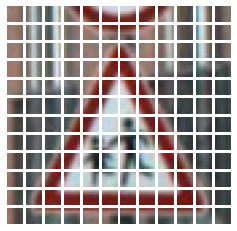

In [ ]:
# display patches for a sample image
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image  = list(dataset_train_72.take(1))[0][0][0]
plt.imshow(image.numpy().astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# Build the ViT model
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    #augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

Epoch 1/100
1569/1569 [==============================] - 75s 42ms/step - loss: 3.3564 - accuracy: 0.1147 - top-5-accuracy: 0.3834 - val_loss: 1.8800 - val_accuracy: 0.4070 - val_top-5-accuracy: 0.7665
Epoch 2/100
1569/1569 [==============================] - 64s 41ms/step - loss: 1.2874 - accuracy: 0.5924 - top-5-accuracy: 0.8822 - val_loss: 0.4278 - val_accuracy: 0.8706 - val_top-5-accuracy: 0.9871
Epoch 3/100
1569/1569 [==============================] - 64s 41ms/step - loss: 0.4405 - accuracy: 0.8599 - top-5-accuracy: 0.9857 - val_loss: 0.1632 - val_accuracy: 0.9499 - val_top-5-accuracy: 0.9948
Epoch 4/100
1569/1569 [==============================] - 64s 41ms/step - loss: 0.2499 - accuracy: 0.9227 - top-5-accuracy: 0.9929 - val_loss: 0.1111 - val_accuracy: 0.9700 - val_top-5-accuracy: 0.9957
Epoch 5/100
1569/1569 [==============================] - 64s 41ms/step - loss: 0.1994 - accuracy: 0.9370 - top-5-accuracy: 0.9951 - val_loss: 0.0891 - val_accuracy: 0.9737 - val_top-5-accuracy: 0.

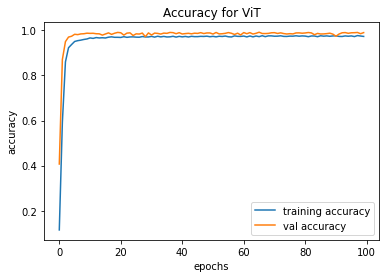

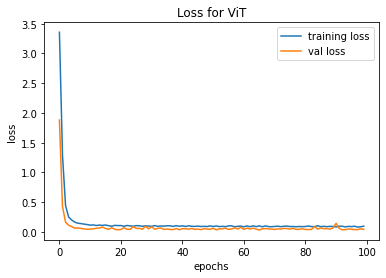

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        dataset_train_norm_72,
        batch_size=256,
        epochs=num_epochs,
        validation_data=dataset_val_norm_72,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(dataset_test_norm_72)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    #print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    _, accuracy, top_5_accuracy = model.evaluate(blurry_test_norm_72)
    print(f"Blury accuracy: {round(accuracy * 100, 2)}%")
    return history

start = time.time()
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)
stop = time.time()
print(f"Execution time: {stop - start}s")

# accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy for ViT')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss for ViT')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## VGG16

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# do not need to train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(vgg.output)
prediction = Dense(43, activation='softmax')(x)

In [ ]:
# create a model 
model_VGG16 = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
# the structure of the model
model_VGG16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#Compilation of the model
model_VGG16.compile(loss='sparse_categorical_crossentropy', optimizer=opt , metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [ ]:
# Train the Model
start = time.time()
history = model_VGG16.fit(dataset_train_norm_224, batch_size=32, validation_data=dataset_val_224, epochs=100, callbacks=early_stop)
stop = time.time()
print(f"Execution time: {stop - start}s")

Epoch 1/100
1569/1569 [==============================] - 48s 25ms/step - loss: 1.2926 - accuracy: 0.6640 - val_loss: 53.5022 - val_accuracy: 0.5526
Epoch 2/100
1569/1569 [==============================] - 37s 23ms/step - loss: 0.6510 - accuracy: 0.8208 - val_loss: 68.8883 - val_accuracy: 0.5678
Epoch 3/100
1569/1569 [==============================] - 37s 23ms/step - loss: 0.5169 - accuracy: 0.8588 - val_loss: 78.6223 - val_accuracy: 0.5598
Epoch 4/100
1569/1569 [==============================] - 37s 23ms/step - loss: 0.4345 - accuracy: 0.8836 - val_loss: 85.6602 - val_accuracy: 0.5706
Epoch 5/100
1569/1569 [==============================] - 37s 23ms/step - loss: 0.3805 - accuracy: 0.8985 - val_loss: 97.8157 - val_accuracy: 0.5599
Epoch 6/100
1569/1569 [==============================] - 37s 23ms/step - loss: 0.3499 - accuracy: 0.9068 - val_loss: 104.5188 - val_accuracy: 0.5645
Epoch 7/100
1569/1569 [==============================] - 37s 23ms/step - loss: 0.3084 - accuracy: 0.9163 - val_

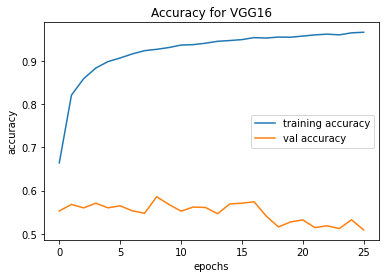

In [ ]:
# accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy for VGG16')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

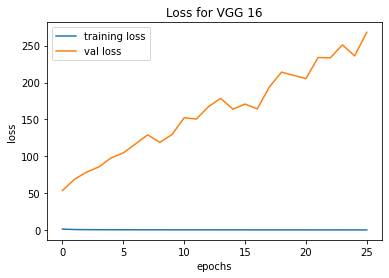

In [ ]:
# Loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss for VGG 16')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
model_VGG16.evaluate(dataset_test_norm_224)

395/395 [==============================] - 12s 28ms/step - loss: 2.4026 - accuracy: 0.7481


[2.4026331901550293, 0.7481393218040466]

In [ ]:
# save the model
from tensorflow.keras.models import load_model
model_VGG16.save('/content/drive/MyDrive/Data 255/Project/saved_models/model_VGG16.h5')

In [ ]:
trained_Vgg = load_model('/content/drive/MyDrive/Data 255/Project/saved_models/model_VGG16.h5')

In [ ]:
trained_Vgg.evaluate(blurry_test_norm_224)

2/2 [==============================] - 1s 478ms/step - loss: 2.1915 - accuracy: 0.7800


[2.1914782524108887, 0.7799999713897705]

## ResNet50

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
# add preprocessing layer to the front of VGG
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# do not need to train existing weights
for layer in resnet.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(resnet.output)
prediction = Dense(43, activation='softmax')(x)

In [ ]:
# create a model 
model_ResNet = Model(inputs=resnet.input, outputs=prediction)

In [ ]:
# the structure of the model
model_ResNet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
#Compilation of the model
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model_ResNet.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
#Train the ResNet Model
start=time.time()
history = model_ResNet.fit(dataset_train_norm_224, batch_size=32, validation_data=dataset_val_norm_224, epochs=100, callbacks=early_stop)
stop = time.time()
print(f"Execution time: {stop - start}s")

Epoch 1/100
1569/1569 [==============================] - 37s 22ms/step - loss: 5.7404 - accuracy: 0.2227 - val_loss: 5.5728 - val_accuracy: 0.1983
Epoch 2/100
1569/1569 [==============================] - 33s 21ms/step - loss: 4.5440 - accuracy: 0.3520 - val_loss: 5.3995 - val_accuracy: 0.2840
Epoch 3/100
1569/1569 [==============================] - 33s 21ms/step - loss: 4.2310 - accuracy: 0.4102 - val_loss: 4.9243 - val_accuracy: 0.3237
Epoch 4/100
1569/1569 [==============================] - 33s 21ms/step - loss: 3.8346 - accuracy: 0.4611 - val_loss: 5.4637 - val_accuracy: 0.3765
Epoch 5/100
1569/1569 [==============================] - 33s 21ms/step - loss: 3.6961 - accuracy: 0.4832 - val_loss: 3.5542 - val_accuracy: 0.4190
Epoch 6/100
1569/1569 [==============================] - 33s 21ms/step - loss: 3.5390 - accuracy: 0.5100 - val_loss: 3.2602 - val_accuracy: 0.4674
Epoch 7/100
1569/1569 [==============================] - 33s 21ms/step - loss: 3.3616 - accuracy: 0.5313 - val_loss: 4

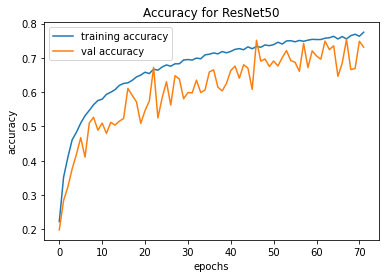

In [ ]:
# accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy for ResNet50')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

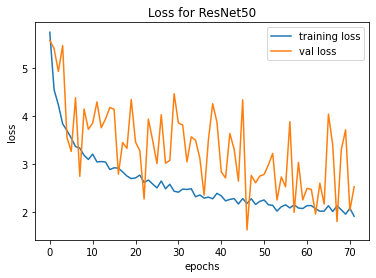

In [ ]:
# Loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss for ResNet50')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# save the model
model_ResNet.save('/content/drive/MyDrive/Data 255/Project/saved_models/model_ResNet.h5')

In [ ]:
model_ResNet.evaluate(dataset_test_norm_224)

395/395 [==============================] - 9s 23ms/step - loss: 5.2420 - accuracy: 0.6516


[5.242031097412109, 0.6516231298446655]

In [ ]:
trained_ResNet = load_model('/content/drive/MyDrive/Data 255/Project/saved_models/model_ResNet.h5')

In [ ]:
trained_ResNet.evaluate(dataset_test_norm_224)

395/395 [==============================] - 10s 22ms/step - loss: 5.2420 - accuracy: 0.6516


[5.242031097412109, 0.6516231298446655]

In [ ]:
trained_ResNet.evaluate(blurry_test_norm_224)

2/2 [==============================] - 0s 208ms/step - loss: 3.7766 - accuracy: 0.6000


[3.776559352874756, 0.6000000238418579]

## Inception V3

In [ ]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
for layer in inception.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(inception.output)

In [ ]:
prediction = Dense(43, activation='softmax')(x)

# create a model object
model_InceptionV3 = Model(inputs=inception.input, outputs=prediction)

In [ ]:
model_InceptionV3.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
#Train the Inception Model
start=time.time()
history = model_InceptionV3.fit(dataset_train_norm_224, batch_size=32, validation_data=dataset_val_norm_224, epochs=100, callbacks=early_stop)
stop = time.time()
print(f"Execution time: {stop - start}s")

Epoch 1/100
1569/1569 [==============================] - 39s 22ms/step - loss: 3.9953 - accuracy: 0.7678 - val_loss: 2.8511 - val_accuracy: 0.8519
Epoch 2/100
1569/1569 [==============================] - 33s 21ms/step - loss: 1.5913 - accuracy: 0.9097 - val_loss: 3.9104 - val_accuracy: 0.8489
Epoch 3/100
1569/1569 [==============================] - 33s 21ms/step - loss: 1.1630 - accuracy: 0.9393 - val_loss: 2.3305 - val_accuracy: 0.9097
Epoch 4/100
1569/1569 [==============================] - 33s 21ms/step - loss: 0.9522 - accuracy: 0.9533 - val_loss: 4.0910 - val_accuracy: 0.8782
Epoch 5/100
1569/1569 [==============================] - 33s 21ms/step - loss: 0.7920 - accuracy: 0.9622 - val_loss: 2.9863 - val_accuracy: 0.9045
Epoch 6/100
1569/1569 [==============================] - 33s 21ms/step - loss: 0.7199 - accuracy: 0.9673 - val_loss: 2.6632 - val_accuracy: 0.9228
Epoch 7/100
1569/1569 [==============================] - 33s 21ms/step - loss: 0.6601 - accuracy: 0.9722 - val_loss: 2

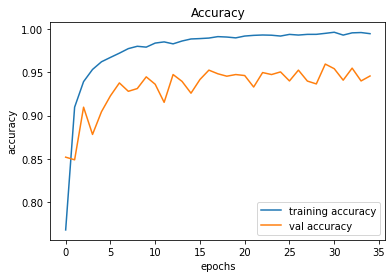

In [ ]:
# accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

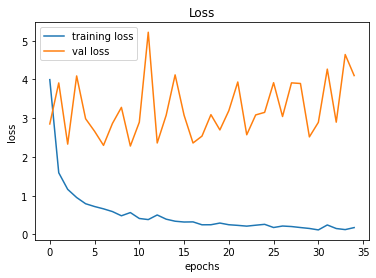

In [ ]:
# Loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
model_InceptionV3.save('/content/drive/MyDrive/Data 255/Project/saved_models/model_InceptionV3.h5')

In [ ]:
model_InceptionV3.evaluate(dataset_test_norm_224)

395/395 [==============================] - 9s 21ms/step - loss: 32.5210 - accuracy: 0.7826


[32.52099609375, 0.7825811505317688]

In [ ]:
model_InceptionV3.evaluate(blurry_test_norm_224)

2/2 [==============================] - 0s 20ms/step - loss: 40.1631 - accuracy: 0.6800


[40.1630744934082, 0.6800000071525574]

In [ ]:
trained_Inception = load_model('/content/drive/MyDrive/Data 255/Project/saved_models/model_InceptionV3.h5')

In [ ]:
trained_Inception.evaluate(dataset_test_norm_224)

395/395 [==============================] - 9s 20ms/step - loss: 32.5210 - accuracy: 0.7826


[32.52099609375, 0.7825811505317688]

In [ ]:
trained_Inception.evaluate(blurry_test_norm_224)

2/2 [==============================] - 0s 367ms/step - loss: 40.1631 - accuracy: 0.6800


[40.1630744934082, 0.6800000071525574]

## MobileNet

In [ ]:
from keras.applications import MobileNetV2
mobilenet = MobileNetV2(include_top=False, input_shape=(224, 224, 3),weights="imagenet")

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# don't train existing weights
for layer in mobilenet.layers:
    layer.trainable = False

In [ ]:
# our layers - you can add more if you want
x = Flatten()(mobilenet.output)

In [ ]:
prediction = Dense(43, activation='softmax')(x)

# create a model object
model_MobileNet = Model(inputs=mobilenet.input, outputs=prediction)

In [ ]:
# view the structure of the model
model_MobileNet.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
# cost and optimization method 
model_MobileNet.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
# Fit the MobileNet Model
start = time.time()
history = model_MobileNet.fit(dataset_train_norm_224, batch_size=32, validation_data= dataset_val_norm_224, epochs=100, callbacks=early_stop)
stop = time.time()
print(f"Execution time: {stop - start}s")

Epoch 1/100
1569/1569 [==============================] - 25s 15ms/step - loss: 4.5966 - accuracy: 0.7872 - val_loss: 2.5009 - val_accuracy: 0.8834
Epoch 2/100
1569/1569 [==============================] - 22s 14ms/step - loss: 1.7951 - accuracy: 0.9198 - val_loss: 2.8590 - val_accuracy: 0.8976
Epoch 3/100
1569/1569 [==============================] - 22s 14ms/step - loss: 1.3447 - accuracy: 0.9447 - val_loss: 4.6893 - val_accuracy: 0.8765
Epoch 4/100
1569/1569 [==============================] - 22s 14ms/step - loss: 1.0852 - accuracy: 0.9582 - val_loss: 3.0648 - val_accuracy: 0.9151
Epoch 5/100
1569/1569 [==============================] - 22s 14ms/step - loss: 1.1329 - accuracy: 0.9616 - val_loss: 3.2297 - val_accuracy: 0.9293
Epoch 6/100
1569/1569 [==============================] - 23s 14ms/step - loss: 0.7754 - accuracy: 0.9735 - val_loss: 3.2989 - val_accuracy: 0.9186
Epoch 7/100
1569/1569 [==============================] - 22s 14ms/step - loss: 0.7722 - accuracy: 0.9759 - val_loss: 2

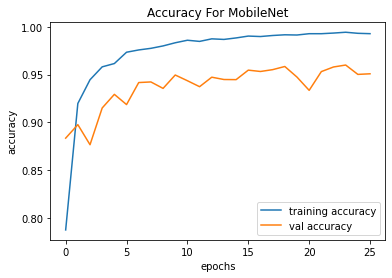

In [ ]:
# accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy For MobileNet')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

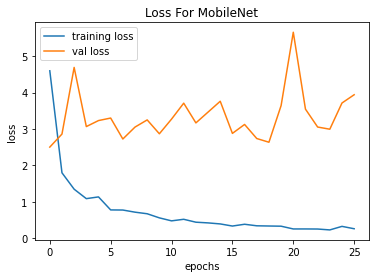

In [ ]:
# Loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss For MobileNet')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
predictions = model_MobileNet.evaluate(dataset_test_norm_224)

395/395 [==============================] - 6s 15ms/step - loss: 30.5956 - accuracy: 0.8032


In [ ]:
model_MobileNet.evaluate(blurry_test_norm_224)

2/2 [==============================] - 0s 131ms/step - loss: 33.3425 - accuracy: 0.7600


[33.34251403808594, 0.7599999904632568]

In [ ]:
model_MobileNet.save('/content/drive/MyDrive/Data 255/Project/saved_models/model_MobileNet.h5')

In [ ]:
trained_MobileNet = load_model('/content/drive/MyDrive/Data 255/Project/saved_models/model_MobileNet.h5')

In [ ]:
trained_MobileNet.evaluate(dataset_test_norm_224)

395/395 [==============================] - 7s 15ms/step - loss: 30.5956 - accuracy: 0.8032


[30.595598220825195, 0.8031670451164246]

In [ ]:
trained_MobileNet.evaluate(blurry_test_norm_224)

2/2 [==============================] - 0s 14ms/step - loss: 33.3425 - accuracy: 0.7600


[33.34251403808594, 0.7599999904632568]

## EfficientNet

In [ ]:
from keras.applications import EfficientNetB0
efficientnet = EfficientNetB0(include_top=False, input_shape=(224, 224, 3),weights="imagenet")

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
# don't train existing weights
for layer in efficientnet.layers:
    layer.trainable = False

In [ ]:
# our layers
x = Flatten()(efficientnet.output)

In [ ]:
prediction = Dense(43, activation='softmax')(x)

# create a model object
model_EfficientNet = Model(inputs=efficientnet.input, outputs=prediction)

In [ ]:
# view the structure of the model
model_EfficientNet.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_8[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling_1[0][0]']            
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']    

In [ ]:
# cost and optimization method 
model_EfficientNet.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
#fit the EfficientNet model
start = time.time()
history = model_EfficientNet.fit(dataset_train_norm_224, batch_size=32, validation_data= dataset_val_norm_224, epochs=100, callbacks=early_stop)
stop = time.time()
print(f"Execution time: {stop - start}s")

Epoch 1/100
1569/1569 [==============================] - 37s 20ms/step - loss: 12.4612 - accuracy: 0.0375 - val_loss: 14.4172 - val_accuracy: 0.0171
Epoch 2/100
1569/1569 [==============================] - 29s 19ms/step - loss: 11.9558 - accuracy: 0.0382 - val_loss: 16.1851 - val_accuracy: 0.0361
Epoch 3/100
1569/1569 [==============================] - 29s 19ms/step - loss: 12.2490 - accuracy: 0.0418 - val_loss: 18.4626 - val_accuracy: 0.0062
Epoch 4/100
1569/1569 [==============================] - 29s 18ms/step - loss: 12.0863 - accuracy: 0.0416 - val_loss: 11.5179 - val_accuracy: 0.0667
Epoch 5/100
1569/1569 [==============================] - 29s 19ms/step - loss: 12.5942 - accuracy: 0.0417 - val_loss: 15.8288 - val_accuracy: 0.0518
Epoch 6/100
1569/1569 [==============================] - 29s 19ms/step - loss: 12.0578 - accuracy: 0.0435 - val_loss: 9.8114 - val_accuracy: 0.0269
Epoch 7/100
1569/1569 [==============================] - 29s 19ms/step - loss: 12.2295 - accuracy: 0.0427 -

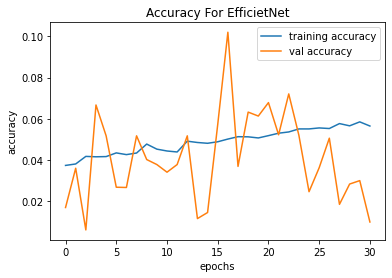

In [ ]:
# accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy For EfficietNet')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

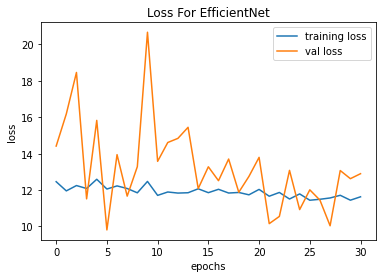

In [ ]:
# Loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss For EfficientNet')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
model_EfficientNet.evaluate(dataset_test_norm_224)

395/395 [==============================] - 8s 20ms/step - loss: 12.6002 - accuracy: 0.0106


[12.600190162658691, 0.010609659366309643]

In [ ]:
model_EfficientNet.evaluate(blurry_test_norm_224)

2/2 [==============================] - 0s 147ms/step - loss: 14.5157 - accuracy: 0.0000e+00


[14.515703201293945, 0.0]

In [ ]:
model_EfficientNet.save('/content/drive/MyDrive/Data 255/Project/saved_models/model_EfficientNet.h5')

In [ ]:
trained_EfficientNet = load_model('/content/drive/MyDrive/Data 255/Project/saved_models/model_EfficientNet.h5')

In [ ]:
trained_EfficientNet.evaluate(dataset_test_norm_224)

395/395 [==============================] - 9s 20ms/step - loss: 12.6002 - accuracy: 0.0106


[12.600213050842285, 0.010609659366309643]

In [ ]:
trained_EfficientNet.evaluate(blurry_test_norm_224)

2/2 [==============================] - 0s 17ms/step - loss: 14.5158 - accuracy: 0.0000e+00


[14.515839576721191, 0.0]

## VGG16 with Tuner

In [ ]:
class MyHyperModel(kt.HyperModel):
    '''create subclass of MyHyperModel class for tuning hyperparameters'''
    def build(self, hp):
      IMAGE_SIZE = [224, 224]

      # add preprocessing layer to the front of VGG
      vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

      # do not need to train existing weights
      for layer in vgg.layers:
        layer.trainable = False

      x = Flatten()(vgg.output)
      prediction = Dense(43, activation='softmax')(x)

      # create a model 
      model_VGG16 = Model(inputs=vgg.input, outputs=prediction)

      #model optimizer options
      hp_optimizer=hp.Choice('Optimizer', values=['Adam', 'SGD'])
      if hp_optimizer == 'Adam':
          optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])) #try continuous values
      elif hp_optimizer == 'SGD':
          optimizer=keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]),
          nesterov=True,
          # momentum=hp.Choice('momentum', values=[.7, .8, .9])
          )

      #Compilation of the model
      model_VGG16.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, #hp option
                          metrics=[
                keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
            ])

      # the structure of the model
      model_VGG16.summary()

      return model_VGG16

In [ ]:
vgg16_model = MyHyperModel()

tuner = kt.tuners.BayesianOptimization(
    vgg16_model,
    seed=10,
    objective='val_loss',
    max_trials=num_trials,
    overwrite=True
    )

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
tuner.search(dataset_train_norm_224, epochs=tuner_epochs, batch_size=32, 
             validation_data=dataset_val_224, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Trial 10 Complete [00h 02m 19s]
val_loss: 14.768899917602539

Best val_loss So Far: 12.771498680114746
Total elapsed time: 00h 24m 07s


In [ ]:
vgg16_best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
#return list of best to worst hyperparams as objects, 0 index is the best
#object acts as a dict
print("Best Hyper-parameters")
vgg16_best_hyperparameters.values #dict

#reduce learning rate, increase epochs
#learning schedule for SGD, remove momentum

Best Hyper-parameters


{'Optimizer': 'SGD', 'learning_rate': 0.001, 'momentum': 0.7}

In [ ]:
#build model with best hyperparameters
vgg16_model=tuner.hypermodel.build(vgg16_best_hyperparameters)

start_time = time()

#refit model with best hyperparameters
history=vgg16_model.fit(dataset_train_norm_224, epochs=num_epochs, batch_size=32, 
                        validation_data=dataset_val_224, callbacks=EarlyStopping(monitor='val_loss', patience=3))

vgg16_tt = round((time() - start_time) / 60, 2)
print('VGG16 - Training Time: {} mins'.format(vgg16_tt))

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

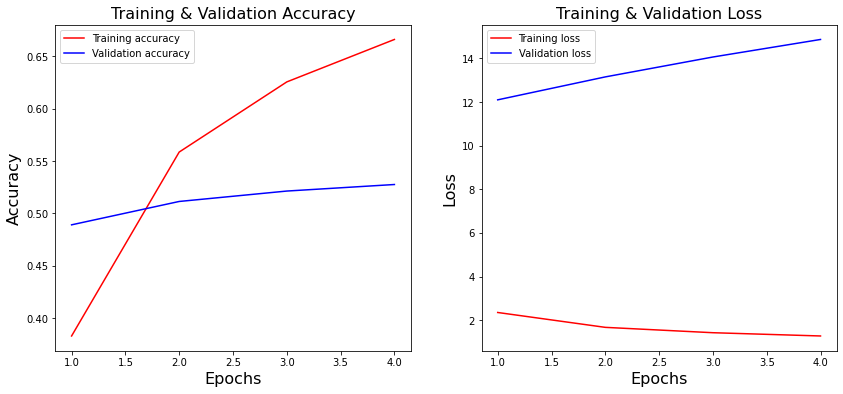

In [ ]:
#defines value to plot
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

#define x and y axis
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the model accuracy vs Epochs
ax[0].plot(epochs, accuracy, 'b', color='red', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()

# Plot the loss vs Epochs
ax[1].plot(epochs, loss_values, 'b', color='red', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

In [ ]:
loss, accuracy, top_5_accuracy = vgg16_model.evaluate(dataset_test_norm_224)

395/395 [==============================] - 10s 26ms/step - loss: 1.5562 - accuracy: 0.5766 - top-5-accuracy: 0.8109


In [ ]:
blurry_loss, blurry_accuracy, blurry_top_5_accuracy = vgg16_model.evaluate(blurry_test_norm_224)

2/2 [==============================] - 0s 18ms/step - loss: 1.5051 - accuracy: 0.6200 - top-5-accuracy: 0.8400


In [ ]:
#add metrics to results dataframe
new_row = ['VGG16', vgg16_best_hyperparameters.values, vgg16_tt, accuracy,top_5_accuracy]
results.loc[len(results)] = new_row

new_row = ['VGG16 Blurry', None, None, blurry_accuracy, blurry_top_5_accuracy]
results.loc[len(results)] = new_row

results

,Model,Best Hyperparameters,Training Time,Accuracy Score,Top 5 Accuracy
0,Haloi,"{'dropout_rate': 0.8, 'hidden_layer': 100, 'hi...",1.95,0.959303,0.993824
1,Haloi Blurry,None,NaN,1.000000,1.000000
2,Haloi Bayes,"{'Optimizer': 'SGD', 'learning_rate': 0.01, 'm...",2.63,0.946714,0.992003
3,Haloi Bayes Blurry,None,NaN,0.960000,1.000000
4,VGG16,"{'Optimizer': 'SGD', 'learning_rate': 0.001, '...",2.30,0.578860,0.811401
5,VGG16 Blurry,None,NaN,0.580000,0.840000


In [ ]:
# save the model
vgg16_model.save("VGG16.h5")

## ResNet50 with Tuner

In [ ]:
class MyHyperModel(kt.HyperModel):
    '''create subclass of MyHyperModel class for tuning hyperparameters'''
    def build(self, hp):
      IMAGE_SIZE = [224, 224]

      # add preprocessing layer to the front of VGG
      resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

      # do not need to train existing weights
      for layer in resnet.layers:
        layer.trainable = False

      x = Flatten()(resnet.output)
      prediction = Dense(43, activation='softmax')(x)

      # create a model 
      model_ResNet = Model(inputs=resnet.input, outputs=prediction)

      #model optimizer options
      hp_optimizer=hp.Choice('Optimizer', values=['Adam', 'SGD'])
      if hp_optimizer == 'Adam':
          optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3]))
      elif hp_optimizer == 'SGD':
          optimizer=keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3]),
          nesterov=True,
          momentum=hp.Choice('momentum', values=[.7, .8, .9]))

      model_ResNet.summary()
      
      #Compilation of the model
      model_ResNet.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, #hp option
                          metrics=[
                keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"), 
            ])

      return model_ResNet

In [ ]:
model_ResNet = MyHyperModel()

tuner = kt.tuners.BayesianOptimization(
    model_ResNet,
    seed=10,
    objective='val_loss',
    max_trials=num_trials,
    overwrite=True
    )

94765736/94765736 [==============================] - 1s 0us/step
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [ ]:
tuner.search(dataset_train_norm_224, epochs=tuner_epochs, batch_size=32, 
             validation_data=dataset_val_224, callbacks=early_stop)

Trial 10 Complete [00h 02m 24s]
val_loss: 62.724571228027344

Best val_loss So Far: 35.73221969604492
Total elapsed time: 00h 24m 10s


In [ ]:
resnet50_best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
#return list of best to worst hyperparams as objects, 0 index is the best
#object acts as a dict
print("Best Hyper-parameters")
resnet50_best_hyperparameters.values #dict

Best Hyper-parameters


{'Optimizer': 'SGD', 'learning_rate': 0.001, 'momentum': 0.7}

In [ ]:
#build model with best hyperparameters
resnet50_model=tuner.hypermodel.build(resnet50_best_hyperparameters)

start_time = time()

#refit model with best hyperparameters
history=resnet50_model.fit(dataset_train_norm_224, epochs=num_epochs, batch_size=32, 
                        validation_data=dataset_val_224, callbacks=early_stop)

resnet50_tt = round((time() - start_time) / 60, 2)
print('ResNet50 - Training Time: {} mins'.format(resnet50_tt))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

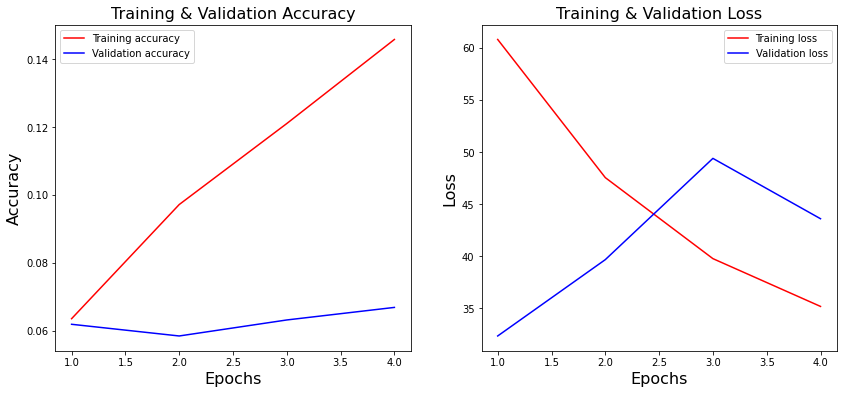

In [ ]:
#defines value to plot
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

#define x and y axis
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the model accuracy vs Epochs
ax[0].plot(epochs, accuracy, 'b', color='red', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()

# Plot the loss vs Epochs
ax[1].plot(epochs, loss_values, 'b', color='red', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

In [ ]:
# save the model
resnet50_model.save("ResNet50.h5")

In [ ]:
loss, accuracy, top_5_accuracy = resnet50_model.evaluate(dataset_test_norm_224)

395/395 [==============================] - 9s 23ms/step - loss: 30.2682 - accuracy: 0.0909 - top-5-accuracy: 0.3038


In [ ]:
blurry_loss, blurry_accuracy, blurry_top_5_accuracy = resnet50_model.evaluate(blurry_test_norm_224)

2/2 [==============================] - 0s 179ms/step - loss: 32.2336 - accuracy: 0.0400 - top-5-accuracy: 0.2800


In [ ]:
#add metrics to results dataframe
new_row = ['ResNet50', resnet50_best_hyperparameters.values, resnet50_tt, accuracy,top_5_accuracy]
results.loc[len(results)] = new_row

new_row = ['ResNet50 Blurry', None, None, blurry_accuracy, blurry_top_5_accuracy]
results.loc[len(results)] = new_row

results

,Model,Best Hyperparameters,Training Time,Accuracy Score,Top 5 Accuracy
0,Haloi,"{'dropout_rate': 0.8, 'hidden_layer': 100, 'hi...",1.95,0.959303,0.993824
1,Haloi Blurry,None,NaN,1.000000,1.000000
2,Haloi Bayes,"{'Optimizer': 'SGD', 'learning_rate': 0.01, 'm...",2.63,0.946714,0.992003
3,Haloi Bayes Blurry,None,NaN,0.960000,1.000000
4,VGG16,"{'Optimizer': 'SGD', 'learning_rate': 0.001, '...",2.30,0.578860,0.811401
5,VGG16 Blurry,None,NaN,0.580000,0.840000
6,ResNet50,"{'Optimizer': 'SGD', 'learning_rate': 0.001, '...",2.26,0.090895,0.303800
7,ResNet50 Blurry,None,NaN,0.040000,0.280000


## Inception V3 with Tuner

In [ ]:
class MyHyperModel(kt.HyperModel):
    '''create subclass of MyHyperModel class for tuning hyperparameters'''
    def build(self, hp):
      IMAGE_SIZE = [224, 224]

      inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

      for layer in inception.layers:
          layer.trainable = False

      x = Flatten()(inception.output)

      prediction = Dense(43, activation='softmax')(x)

      # create a model object
      model_InceptionV3 = Model(inputs=inception.input, outputs=prediction)

      #model optimizer options
      hp_optimizer=hp.Choice('Optimizer', values=['Adam', 'SGD'])
      if hp_optimizer == 'Adam':
          optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3]))
      elif hp_optimizer == 'SGD':
          optimizer=keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3]),
          nesterov=True,
          momentum=hp.Choice('momentum', values=[.7, .8, .9]))

      #Compilation of the model
      model_InceptionV3.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, #hp option
                          metrics=[
                keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"), 
            ])

      # the structure of the model
      model_InceptionV3.summary()

      return model_InceptionV3

In [ ]:
model_InceptionV3 = MyHyperModel()

tuner = kt.tuners.BayesianOptimization(
    model_InceptionV3,
    seed=10,
    objective='val_loss',
    max_trials=num_trials,
    overwrite=True
    )

87910968/87910968 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                

In [ ]:
tuner.search(dataset_train_norm_224, epochs=tuner_epochs, batch_size=32, 
             validation_data=dataset_val_224, callbacks=early_stop)

Trial 10 Complete [00h 02m 52s]
val_loss: 82.11127471923828

Best val_loss So Far: 82.11127471923828
Total elapsed time: 00h 29m 00s


In [ ]:
Incv3_best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
#return list of best to worst hyperparams as objects, 0 index is the best
#object acts as a dict
print("Best Hyper-parameters")
Incv3_best_hyperparameters.values #dict

Best Hyper-parameters


{'Optimizer': 'SGD', 'learning_rate': 0.001, 'momentum': 0.7}

In [ ]:
#build model with best hyperparameters
model_InceptionV3=tuner.hypermodel.build(Incv3_best_hyperparameters)

start_time = time()

#refit model with best hyperparameters
history=model_InceptionV3.fit(dataset_train_norm_224, epochs=num_epochs, batch_size=32, 
                        validation_data=dataset_val_224, callbacks=[EarlyStopping(monitor='val_loss', 
                                                                                  patience=5)])

Incv3_tt = round((time() - start_time) / 60, 2)
print('Inception V3 - Training Time: {} mins'.format(Incv3_tt))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

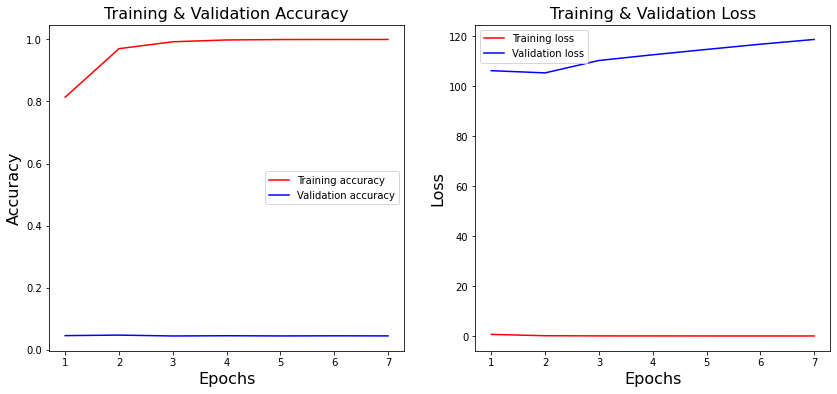

In [ ]:
#defines value to plot
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

#define x and y axis
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the model accuracy vs Epochs
ax[0].plot(epochs, accuracy, 'b', color='red', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()

# Plot the loss vs Epochs
ax[1].plot(epochs, loss_values, 'b', color='red', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

In [ ]:
# save the model
model_InceptionV3.save("model_InceptionV3.h5")

In [ ]:
loss, accuracy, top_5_accuracy = model_InceptionV3.evaluate(dataset_test_norm_224)

395/395 [==============================] - 9s 21ms/step - loss: 0.7036 - accuracy: 0.8110 - top-5-accuracy: 0.9608


In [ ]:
blurry_loss, blurry_accuracy, blurry_top_5_accuracy = model_InceptionV3.evaluate(blurry_test_norm_224)

2/2 [==============================] - 0s 350ms/step - loss: 1.3264 - accuracy: 0.6000 - top-5-accuracy: 0.9400


In [ ]:
#add metrics to results dataframe
new_row = ['Inception V3', Incv3_best_hyperparameters.values, Incv3_tt, accuracy,top_5_accuracy]
results.loc[len(results)] = new_row

new_row = ['Inception V3 Blurry', None, None, blurry_accuracy, blurry_top_5_accuracy]
results.loc[len(results)] = new_row

results

,Model,Best Hyperparameters,Training Time,Accuracy Score,Top 5 Accuracy
0,Haloi,"{'dropout_rate': 0.8, 'hidden_layer': 100, 'hi...",1.95,0.959303,0.993824
1,Haloi Blurry,None,NaN,1.000000,1.000000
2,Haloi Bayes,"{'Optimizer': 'SGD', 'learning_rate': 0.01, 'm...",2.63,0.946714,0.992003
3,Haloi Bayes Blurry,None,NaN,0.960000,1.000000
4,VGG16,"{'Optimizer': 'SGD', 'learning_rate': 0.001, '...",2.30,0.578860,0.811401
5,VGG16 Blurry,None,NaN,0.580000,0.840000
6,ResNet50,"{'Optimizer': 'SGD', 'learning_rate': 0.001, '...",2.26,0.090895,0.303800
7,ResNet50 Blurry,None,NaN,0.040000,0.280000
8,Inception V3,"{'Optimizer': 'SGD', 'learning_rate': 0.001, '...",4.03,0.811006,0.960808
9,Inception V3 Blurry,None,NaN,0.600000,0.940000


## MobileNet with Tuner

In [ ]:
class MyHyperModel(kt.HyperModel):
    '''create subclass of MyHyperModel class for tuning hyperparameters'''
    def build(self, hp):
      
      mobilenet = MobileNetV2(include_top=False, input_shape=(224, 224, 3),weights="imagenet")

      # don't train existing weights
      for layer in mobilenet.layers:
          layer.trainable = False

      # our layers - you can add more if you want
      x = Flatten()(mobilenet.output)

      prediction = Dense(43, activation='softmax')(x)

      # create a model object
      model_MobileNet = Model(inputs=mobilenet.input, outputs=prediction)

      # view the structure of the model
      model_MobileNet.summary()

      #model optimizer options
      hp_optimizer=hp.Choice('Optimizer', values=['Adam', 'SGD'])
      if hp_optimizer == 'Adam':
          optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3]))
      elif hp_optimizer == 'SGD':
          optimizer=keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3]),
          nesterov=True,
          momentum=hp.Choice('momentum', values=[.7, .8, .9]))

      #Compilation of the model
      model_MobileNet.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, #hp option
                          metrics=[
                keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
            ])

      # the structure of the model
      model_MobileNet.summary()

      return model_MobileNet

In [ ]:
model_MobileNet = MyHyperModel()

tuner = kt.tuners.BayesianOptimization(
    model_MobileNet,
    seed=10,
    objective='val_loss',
    max_trials=num_trials,
    overwrite=True
    )

9406464/9406464 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                             

In [ ]:
tuner.search(dataset_train_norm_224, epochs=tuner_epochs, batch_size=32, 
             validation_data=dataset_val_224, callbacks=early_stop)

Trial 10 Complete [00h 02m 32s]
val_loss: 8.641252517700195

Best val_loss So Far: 8.035329818725586
Total elapsed time: 00h 22m 05s


In [ ]:
mobile_best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
#return list of best to worst hyperparams as objects, 0 index is the best
#object acts as a dict
print("Best Hyper-parameters")
mobile_best_hyperparameters.values #dict

Best Hyper-parameters


{'Optimizer': 'SGD', 'learning_rate': 0.001, 'momentum': 0.7}

In [ ]:
#build model with best hyperparameters
model_MobileNet=tuner.hypermodel.build(mobile_best_hyperparameters)

start_time = time()

#refit model with best hyperparameters
history=model_MobileNet.fit(dataset_train_norm_224, epochs=num_epochs, batch_size=32, 
                        validation_data=dataset_val_224, callbacks=early_stop)

mobile_tt = round((time() - start_time) / 60, 2)
print('MobileNet - Training Time: {} mins'.format(mobile_tt))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

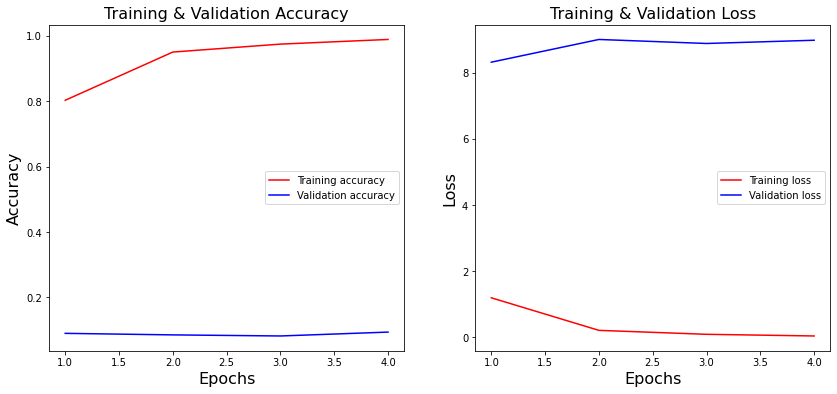

In [ ]:
#defines value to plot
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

#define x and y axis
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the model accuracy vs Epochs
ax[0].plot(epochs, accuracy, 'b', color='red', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()

# Plot the loss vs Epochs
ax[1].plot(epochs, loss_values, 'b', color='red', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

In [ ]:
# save the model
model_MobileNet.save("model_MobileNet.h5")

In [ ]:
loss, accuracy, top_5_accuracy = model_MobileNet.evaluate(dataset_test_norm_224)

395/395 [==============================] - 6s 16ms/step - loss: 1.1368 - accuracy: 0.8181 - top-5-accuracy: 0.9525


In [ ]:
blurry_loss, blurry_accuracy, blurry_top_5_accuracy = model_MobileNet.evaluate(blurry_test_norm_224)

2/2 [==============================] - 0s 120ms/step - loss: 1.2821 - accuracy: 0.7400 - top-5-accuracy: 0.9400


In [ ]:
#add metrics to results dataframe
new_row = ['MobileNet', mobile_best_hyperparameters.values, mobile_tt, accuracy,top_5_accuracy]
results.loc[len(results)] = new_row

new_row = ['MobileNet Blurry', None, None, blurry_accuracy, blurry_top_5_accuracy]
results.loc[len(results)] = new_row

results

,Model,Best Hyperparameters,Training Time,Accuracy Score,Top 5 Accuracy
0,Haloi,"{'dropout_rate': 0.8, 'hidden_layer': 100, 'hi...",1.95,0.959303,0.993824
1,Haloi Blurry,None,NaN,1.000000,1.000000
2,Haloi Bayes,"{'Optimizer': 'SGD', 'learning_rate': 0.01, 'm...",2.63,0.946714,0.992003
3,Haloi Bayes Blurry,None,NaN,0.960000,1.000000
4,VGG16,"{'Optimizer': 'SGD', 'learning_rate': 0.001, '...",2.30,0.578860,0.811401
5,VGG16 Blurry,None,NaN,0.580000,0.840000
6,ResNet50,"{'Optimizer': 'SGD', 'learning_rate': 0.001, '...",2.26,0.090895,0.303800
7,ResNet50 Blurry,None,NaN,0.040000,0.280000
8,Inception V3,"{'Optimizer': 'SGD', 'learning_rate': 0.001, '...",4.03,0.811006,0.960808
9,Inception V3 Blurry,None,NaN,0.600000,0.940000


## Efficient Net with Tuner

In [ ]:
class MyHyperModel(kt.HyperModel):
    '''create subclass of MyHyperModel class for tuning hyperparameters'''
    def build(self, hp):
      
      efficientnet = EfficientNetB0(include_top=False, input_shape=(224, 224, 3),weights="imagenet")

      # don't train existing weights
      for layer in efficientnet.layers:
          layer.trainable = False

      # our layers
      x = Flatten()(efficientnet.output)

      prediction = Dense(43, activation='softmax')(x)

      # create a model object
      model_EfficientNet = Model(inputs=efficientnet.input, outputs=prediction)

      # view the structure of the model
      model_EfficientNet.summary()

      #model optimizer options
      hp_optimizer=hp.Choice('Optimizer', values=['Adam', 'SGD'])
      if hp_optimizer == 'Adam':
          optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3]))
      elif hp_optimizer == 'SGD':
          optimizer=keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3]),
          nesterov=True,
          momentum=hp.Choice('momentum', values=[.7, .8, .9]))

      #Compilation of the model
      model_EfficientNet.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, #hp option
                          metrics=[
                keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
            ])

      # the structure of the model
      model_EfficientNet.summary()

      return model_EfficientNet

In [ ]:
model_EfficientNet = MyHyperModel()

tuner = kt.tuners.BayesianOptimization(
    model_EfficientNet,
    seed=10,
    objective='val_loss',
    max_trials=num_trials,
    overwrite=True
    )

16705208/16705208 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambd

In [ ]:
tuner.search(dataset_train_norm_224, epochs=tuner_epochs, batch_size=32, 
             validation_data=dataset_val_224, callbacks=early_stop)

Trial 10 Complete [00h 02m 37s]
val_loss: 4.4688286781311035

Best val_loss So Far: 4.318897247314453
Total elapsed time: 00h 26m 53s


In [ ]:
efficient_best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
#return list of best to worst hyperparams as objects, 0 index is the best
#object acts as a dict
print("Best Hyper-parameters")
efficient_best_hyperparameters.values #dict

Best Hyper-parameters


{'Optimizer': 'SGD', 'learning_rate': 0.001, 'momentum': 0.7}

In [ ]:
#build model with best hyperparameters
model_EfficientNet=tuner.hypermodel.build(efficient_best_hyperparameters)

start_time = time()

#refit model with best hyperparameters
history=model_EfficientNet.fit(dataset_train_norm_224, epochs=num_epochs, batch_size=32, 
                        validation_data=dataset_val_224, callbacks=early_stop)

efficient_tt = round((time() - start_time) / 60, 2)
print('Efficient Net - Training Time: {} mins'.format(efficient_tt))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

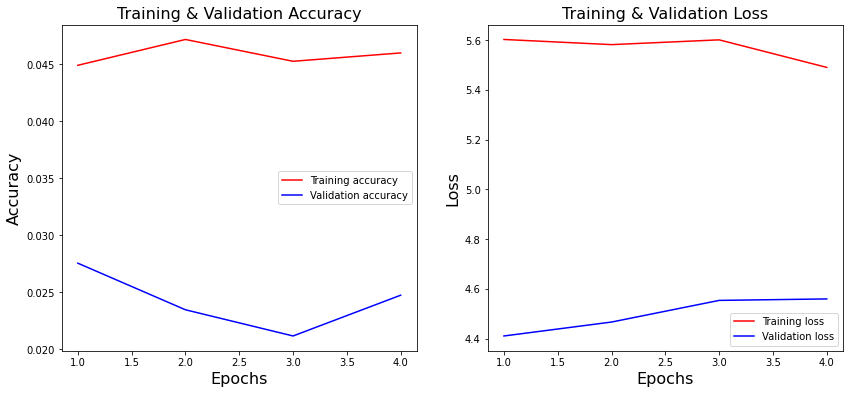

In [ ]:
#defines value to plot
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

#define x and y axis
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the model accuracy vs Epochs
ax[0].plot(epochs, accuracy, 'b', color='red', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()

# Plot the loss vs Epochs
ax[1].plot(epochs, loss_values, 'b', color='red', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

In [ ]:
loss, accuracy, top_5_accuracy = model_EfficientNet.evaluate(dataset_test_norm_224)

395/395 [==============================] - 8s 21ms/step - loss: 6.4066 - accuracy: 0.0166 - top-5-accuracy: 0.1211


In [ ]:
blurry_loss, blurry_accuracy, blurry_top_5_accuracy = model_EfficientNet.evaluate(blurry_test_norm_224)

2/2 [==============================] - 0s 133ms/step - loss: 7.0611 - accuracy: 0.0000e+00 - top-5-accuracy: 0.0000e+00


In [ ]:
#add metrics to results dataframe
new_row = ['Efficient Net', efficient_best_hyperparameters.values, efficient_tt, accuracy,top_5_accuracy]
results.loc[len(results)] = new_row

new_row = ['Efficient Net Blurry', None, None, blurry_accuracy, blurry_top_5_accuracy]
results.loc[len(results)] = new_row

results

,Model,Best Hyperparameters,Training Time,Accuracy Score,Top 5 Accuracy
0,Haloi,"{'dropout_rate': 0.8, 'hidden_layer': 100, 'hi...",1.95,0.959303,0.993824
1,Haloi Blurry,None,NaN,1.000000,1.000000
2,Haloi Bayes,"{'Optimizer': 'SGD', 'learning_rate': 0.01, 'm...",2.63,0.946714,0.992003
3,Haloi Bayes Blurry,None,NaN,0.960000,1.000000
4,VGG16,"{'Optimizer': 'SGD', 'learning_rate': 0.001, '...",2.30,0.578860,0.811401
5,VGG16 Blurry,None,NaN,0.580000,0.840000
6,ResNet50,"{'Optimizer': 'SGD', 'learning_rate': 0.001, '...",2.26,0.090895,0.303800
7,ResNet50 Blurry,None,NaN,0.040000,0.280000
8,Inception V3,"{'Optimizer': 'SGD', 'learning_rate': 0.001, '...",4.03,0.811006,0.960808
9,Inception V3 Blurry,None,NaN,0.600000,0.940000


In [ ]:
# save the model
model_EfficientNet.save("model_EfficientNet.h5")

## Vision Transformer with Tuner

Image size: 72 X 72
Patch size: 8 X 8
Patches per image: 81
Elements per patch: 192


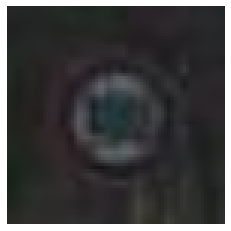

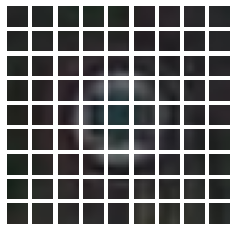

In [ ]:
# Implement patch creation as a layer
class Patches(layers.Layer):
    def __init__(self, patch_size): #hp patch size
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# display patches for a sample image

image_size = 72  # We'll resize input images to this size
patch_size = 8
      # projection_dim = 64

plt.figure(figsize=(4, 4))
image  = list(dataset_train_72.take(1))[0][0][0]
plt.imshow(image.numpy().astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
class MyHyperModel(kt.HyperModel):
    '''create subclass of MyHyperModel class for tuning hyperparameters'''
    def build(self, hp):
      
      #Implement multilayer perceptron (MLP)
      def mlp(x, hidden_units, dropout_rate, activation): #hp all these
          for units in hidden_units:
              x = layers.Dense(units, activation=activation)(x) #tf.nn.gelu, relu
              x = layers.Dropout(dropout_rate)(x)
          return x
          
      # Implement the patch encoding layer
      class PatchEncoder(layers.Layer):
          def __init__(self, num_patches, projection_dim):
              super(PatchEncoder, self).__init__()
              self.num_patches = num_patches
              self.projection_dim = projection_dim
              self.projection = layers.Dense(units=projection_dim)
              self.position_embedding = layers.Embedding(
                  input_dim=num_patches, output_dim=projection_dim
              )

          def call(self, patch):
              positions = tf.range(start=0, limit=self.num_patches, delta=1)
              encoded = self.projection(patch) + self.position_embedding(positions)
              return encoded
          
          def get_config(self):
            config = super().get_config().copy()
            config.update({
                'num_patches': self.num_patches,
                'projection_dim': self.projection_dim
            })
            return config

      # Implement patch creation as a layer
      class Patches(layers.Layer):
          def __init__(self, patch_size): #hp patch size
              super(Patches, self).__init__()
              self.patch_size = patch_size

          def call(self, images):
              batch_size = tf.shape(images)[0]
              patches = tf.image.extract_patches(
                  images=images,
                  sizes=[1, self.patch_size, self.patch_size, 1],
                  strides=[1, self.patch_size, self.patch_size, 1],
                  rates=[1, 1, 1, 1],
                  padding="VALID",
              )
              patch_dims = patches.shape[-1]
              patches = tf.reshape(patches, [batch_size, -1, patch_dims])
              return patches

              
      #hyperparameters to be tuned
      patch_size = hp.Choice('patch_size', values=[6, 8, 12, 18]) #og 6
      transformer_layers = hp.Choice('transformer_layers', values=[8, 12, 16, 24]) #og 8

      #static variables
      num_classes = 43
      input_shape = (72, 72, 3)
      image_size = 72  # We'll resize input images to this size
      projection_dim = 64

      #set the hyperparameters
      batch_size = 256
      num_heads = 4
      num_patches = (image_size // patch_size) ** 2
      transformer_units = [
          projection_dim * 2,
          projection_dim,
      ]  # Size of the transformer layers
      mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


      #creates model
      inputs = layers.Input(shape=input_shape)
      # Augment data.
      #augmented = data_augmentation(inputs)
      # Create patches.
      patches = Patches(patch_size)(inputs) #HP
      # Encode patches.
      encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

      hp_mlp_dropout_rate = hp.Choice('hp_mlp_dropout_rate', values=[0.1, 0.5, 0.6, 0.7, 0.8]) #hp
      hp_mlp_activation = hp.Choice('hp_mlp_activation', values=['relu','gelu']) #hp

      # Create multiple layers of the Transformer block.
      for _ in range(transformer_layers): #HP
          # Layer normalization 1.
          x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
          # Create a multi-head attention layer.
          attention_output = layers.MultiHeadAttention(
              num_heads=num_heads, key_dim=projection_dim, dropout=0.1
          )(x1, x1)
          # Skip connection 1.
          x2 = layers.Add()([attention_output, encoded_patches])
          # Layer normalization 2.
          x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
          # MLP.
          x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=hp_mlp_dropout_rate, activation=hp_mlp_activation)
          # Skip connection 2.
          encoded_patches = layers.Add()([x3, x2])

      # Create a [batch_size, projection_dim] tensor.
      representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
      representation = layers.Flatten()(representation)
      representation = layers.Dropout(0.5)(representation)
      # Add MLP.
      features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=hp_mlp_dropout_rate, activation=hp_mlp_activation)
      # Classify outputs.
      logits = layers.Dense(num_classes)(features)
      # Create the Keras model.
      model = keras.Model(inputs=inputs, outputs=logits)

      # view the structure of the model
      model.summary()


      #model optimizer options
      hp_optimizer=hp.Choice('Optimizer', values=['Adam', 'SGD'])
      if hp_optimizer == 'Adam':
          optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3]),
          decay = hp.Choice('decay', values=[0.0, 1e-1, 1e-2, 1e-3, 1e-4]))
      elif hp_optimizer == 'SGD':
          optimizer=keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3]),
          nesterov=True,
          momentum=hp.Choice('momentum', values=[.7, .8, .9]))

      
      model.compile(
            optimizer=optimizer, #hp
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[
                keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
            ],
        )

      return model

In [ ]:
model_VT = MyHyperModel()

tuner = kt.tuners.BayesianOptimization(
    model_VT,
    seed=10,
    objective='val_loss',
    max_trials=num_trials,
    overwrite=True
    )

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 72, 72, 3)]  0           []                               
                                                                                                  
 patches (Patches)              (None, None, 108)    0           ['input_3[0][0]']                
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 144, 64)      16192       ['patches[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, 144, 64)     128         ['patch_encoder[0][0]']          
 alization)                                                                                 

In [ ]:
tuner.search(dataset_train_norm_72, epochs=tuner_epochs, batch_size=32, #256
             validation_data=dataset_val_72, callbacks=early_stop)

Trial 10 Complete [00h 04m 26s]
val_loss: 3.5232605934143066

Best val_loss So Far: 2.451746940612793
Total elapsed time: 01h 39m 51s


In [ ]:
VT_best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
#return list of best to worst hyperparams as objects, 0 index is the best
#object acts as a dict
print("Best Hyper-parameters")
VT_best_hyperparameters.values #dict

Best Hyper-parameters


{'patch_size': 18,
 'transformer_layers': 24,
 'hp_mlp_dropout_rate': 0.1,
 'hp_mlp_activation': 'relu',
 'Optimizer': 'SGD',
 'learning_rate': 0.01,
 'decay': 0.0,
 'momentum': 0.8}

In [ ]:
#build model with best hyperparameters
model_VT=tuner.hypermodel.build(VT_best_hyperparameters)

start_time = time()

#refit model with best hyperparameters
history=model_VT.fit(dataset_train_norm_72, epochs=num_epochs, batch_size=256, #had 256 for batch size #epochs=num_epochs, batch_size=32
                        validation_data=dataset_val_72, callbacks=early_stop)

VT_tt = round((time() - start_time) / 60, 2)
print('Vision Transformer - Training Time: {} mins'.format(VT_tt))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 72, 72, 3)]  0           []                               
                                                                                                  
 patches_1 (Patches)            (None, None, 972)    0           ['input_2[0][0]']                
                                                                                                  
 patch_encoder_1 (PatchEncoder)  (None, 16, 64)      63296       ['patches_1[0][0]']              
                                                                                                  
 layer_normalization_17 (LayerN  (None, 16, 64)      128         ['patch_encoder_1[0][0]']        
 ormalization)                                                                              

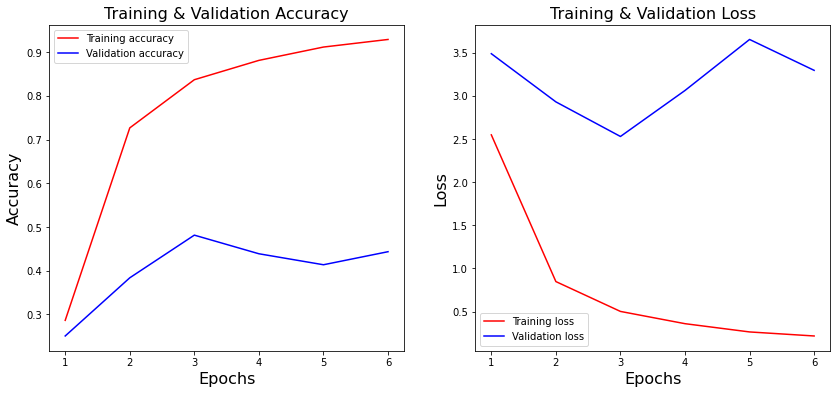

In [ ]:
#defines value to plot
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

#define x and y axis
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the model accuracy vs Epochs
ax[0].plot(epochs, accuracy, 'b', color='red', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()

# Plot the loss vs Epochs
ax[1].plot(epochs, loss_values, 'b', color='red', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

In [ ]:
# # save the model
# model_VT.save("model_VT.h5")
# # cannot save this model

In [ ]:
loss, accuracy, top_5_accuracy = model_VT.evaluate(dataset_test_norm_72)

395/395 [==============================] - 14s 35ms/step - loss: 0.7232 - accuracy: 0.8215 - top-5-accuracy: 0.9692


In [ ]:
blurry_loss, blurry_accuracy, blurry_top_5_accuracy = model_VT.evaluate(blurry_test_norm_72)

2/2 [==============================] - 0s 33ms/step - loss: 0.4604 - accuracy: 0.9000 - top-5-accuracy: 1.0000


In [ ]:
#add metrics to results dataframe
new_row = ['Vision Transformer', VT_best_hyperparameters.values, VT_tt, accuracy,top_5_accuracy]
results.loc[len(results)] = new_row

new_row = ['Vision Transformer Blurry', None, None, blurry_accuracy, blurry_top_5_accuracy]
results.loc[len(results)] = new_row

results

,Model,Best Hyperparameters,Training Time,Accuracy Score,Top 5 Accuracy
0,Haloi,"{'dropout_rate': 0.8, 'hidden_layer': 100, 'hi...",1.95,0.959303,0.993824
1,Haloi Blurry,None,NaN,1.000000,1.000000
2,Haloi Bayes,"{'Optimizer': 'SGD', 'learning_rate': 0.01, 'm...",2.63,0.946714,0.992003
3,Haloi Bayes Blurry,None,NaN,0.960000,1.000000
4,VGG16,"{'Optimizer': 'SGD', 'learning_rate': 0.001, '...",2.30,0.578860,0.811401
5,VGG16 Blurry,None,NaN,0.580000,0.840000
6,ResNet50,"{'Optimizer': 'SGD', 'learning_rate': 0.001, '...",2.26,0.090895,0.303800
7,ResNet50 Blurry,None,NaN,0.040000,0.280000
8,Inception V3,"{'Optimizer': 'SGD', 'learning_rate': 0.001, '...",4.03,0.811006,0.960808
9,Inception V3 Blurry,None,NaN,0.600000,0.940000


# Model Comparison

In [ ]:
# results = pd.read_csv('results.csv')
# results = results[['Model', 'Best Hyperparameters', 'Training Time', 'Accuracy Score', 'Top 5 Accuracy']]
# results

In [ ]:
model_training_results = results.dropna()
#print out of models and best hyperparameters
for i in range(len(results)):
  if results['Training Time'][i]==None or np.isnan(results['Training Time'][i]):
    pass
  else:
    print(model_training_results['Model'][i], model_training_results['Best Hyperparameters'][i])

Haloi {'dropout_rate': 0.8, 'hidden_layer': 100, 'hidden_layer_activation': 'leaky_relu', 'Optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 0.9}
Haloi Bayes {'Optimizer': 'SGD', 'learning_rate': 0.01, 'momentum': 0.7}
VGG16 {'Optimizer': 'SGD', 'learning_rate': 0.001, 'momentum': 0.7}
ResNet50 {'Optimizer': 'SGD', 'learning_rate': 0.001, 'momentum': 0.7}
Inception V3 {'Optimizer': 'SGD', 'learning_rate': 0.001, 'momentum': 0.7}
MobileNet {'Optimizer': 'SGD', 'learning_rate': 0.001, 'momentum': 0.7}
Efficient Net {'Optimizer': 'SGD', 'learning_rate': 0.001, 'momentum': 0.7}
Vision Transformer {'patch_size': 18, 'transformer_layers': 24, 'hp_mlp_dropout_rate': 0.1, 'hp_mlp_activation': 'relu', 'Optimizer': 'SGD', 'learning_rate': 0.01, 'decay': 0.0, 'momentum': 0.8}


In [ ]:
#show results table rounded to 2 decimals
results.to_csv('results.csv')
results.round(2)

,Model,Best Hyperparameters,Training Time,Accuracy Score,Top 5 Accuracy
0,Haloi,"{'dropout_rate': 0.8, 'hidden_layer': 100, 'hi...",1.95,0.96,0.99
1,Haloi Blurry,NaN,NaN,1.00,1.00
2,Haloi Bayes,"{'Optimizer': 'SGD', 'learning_rate': 0.01, 'm...",2.63,0.95,0.99
3,Haloi Bayes Blurry,NaN,NaN,0.96,1.00
4,VGG16,"{'Optimizer': 'SGD', 'learning_rate': 0.001, '...",2.30,0.58,0.81
5,VGG16 Blurry,NaN,NaN,0.58,0.84
6,ResNet50,"{'Optimizer': 'SGD', 'learning_rate': 0.001, '...",2.26,0.09,0.30
7,ResNet50 Blurry,NaN,NaN,0.04,0.28
8,Inception V3,"{'Optimizer': 'SGD', 'learning_rate': 0.001, '...",4.03,0.81,0.96
9,Inception V3 Blurry,NaN,NaN,0.60,0.94


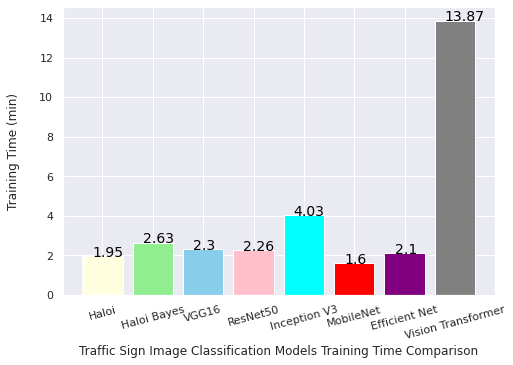

In [ ]:
#bar graph of model training times
sns.set(font_scale=1)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Models = model_training_results['Model']
TrainingTime=model_training_results['Training Time']
ax.bar(Models,TrainingTime,color=["lightyellow","lightgreen", "skyblue", "pink","cyan","red","purple","gray","brown","orange"]);
for i in ax.patches:
    ax.text(i.get_x()+.2, i.get_height(), str(round(i.get_height(),2)), fontsize=14, color='black')
plt.ylabel('Training Time (min)\n');
plt.xticks(rotation = 15)
plt.xlabel('Traffic Sign Image Classification Models Training Time Comparison');
# plt.savefig('fig title.png', bbox_inches='tight')
plt.show();

In [ ]:
accuray_results = results[['Model','Accuracy Score', 'Top 5 Accuracy']]
accuray_results.round(2)

,Model,Accuracy Score,Top 5 Accuracy
0,Haloi,0.96,0.99
1,Haloi Blurry,1.00,1.00
2,Haloi Bayes,0.95,0.99
3,Haloi Bayes Blurry,0.96,1.00
4,VGG16,0.58,0.81
5,VGG16 Blurry,0.58,0.84
6,ResNet50,0.09,0.30
7,ResNet50 Blurry,0.04,0.28
8,Inception V3,0.81,0.96
9,Inception V3 Blurry,0.60,0.94
